In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

- We begin this analysis by taking a look at the crude oil floating storage data and its relationship to crude oil prices for 2017 up to 2020. This will enable us to analyse trends prior to the global pandemic. Were things different? Did relationships change? Did things go back to 'normal' post 2022. 
- We use this 3 year period to determine what 'normal' was. 

In [31]:
#Defining date range for historical analysis
START_DATE = datetime(2017, 1, 1)
END_DATE = datetime(2019, 12, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [29]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

- Fetching Floating Storage data from the Cargo Timeseries endpoint 

In [30]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2017-01-01,165,13246916
1,2017-01-02,167,13579238
2,2017-01-03,182,14405097
3,2017-01-04,177,14528908
4,2017-01-05,183,14380180
...,...,...,...
1089,2019-12-26,162,9757414
1090,2019-12-27,165,9845105
1091,2019-12-28,154,9045261
1092,2019-12-29,132,8326334


- The above dataframe contains the dates spanning January 2017 to December 2019. Approximately a 3 year period. 

Text(0, 0.5, 'Floating Storage (t)')

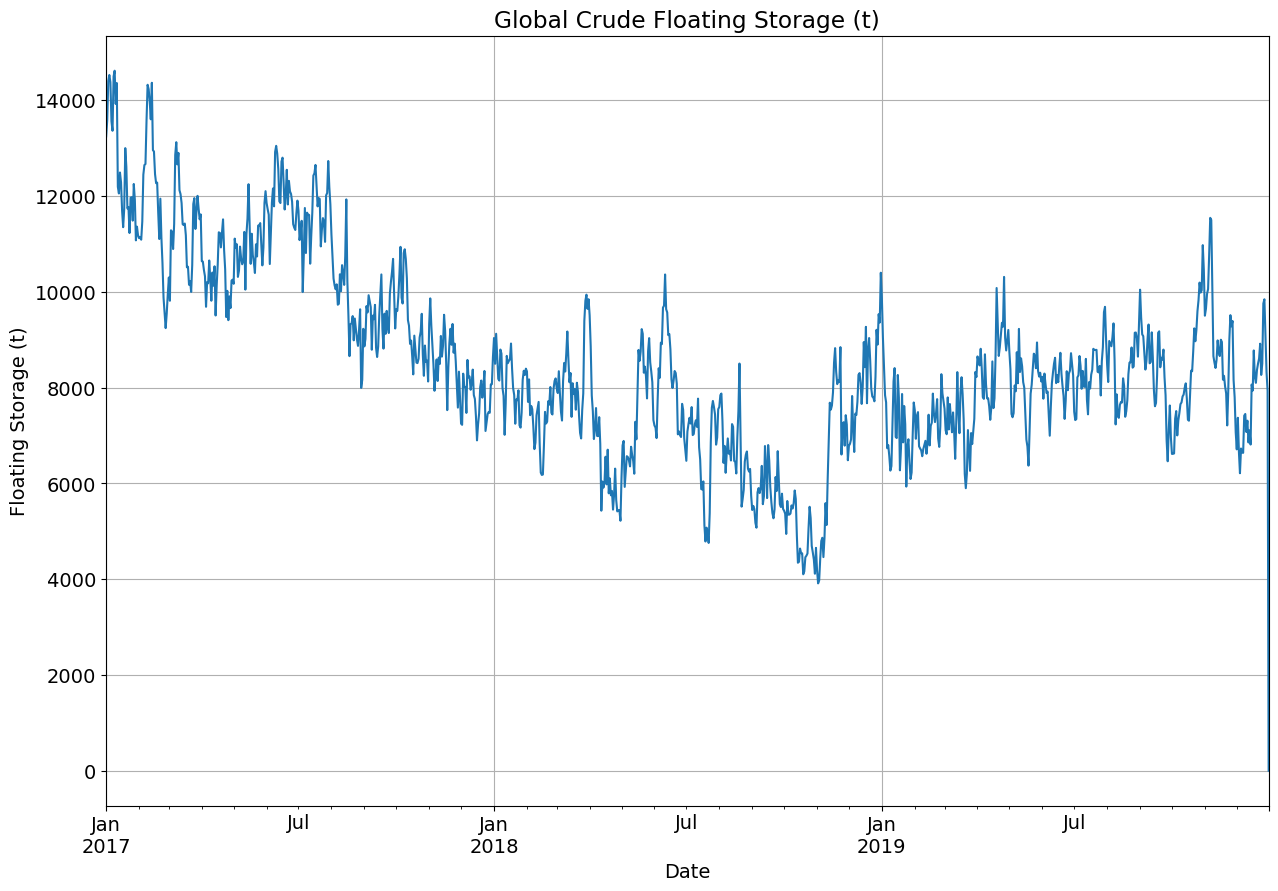

In [7]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

The above is a Pandas Series to hold the floating storage quantity in t and we use this series to plot the data. 

The graph above shows that global floating storage levels experienced moderate fluctuations and generally maintained a downward trend between January 2017, where it experienced its peak at 14,000, and November 2018, where it experienced its trough of 4000. 
Following the start of 2018, floating storage levels maintained some consistency, ranging between 6000 and 10,000. 

Below: EIA crude oil prices
The US Energy Information Administration (EIA) reports daily spot prices of crude oil and other products on their website. This data is publicly available and we download the Excel file directly into a Pandas DataFrame below. (NB: although the series has daily resolution, the Excel file is updated on a weekly basis. For details see the information in the Regular Weekly Releases box.) ffill is used to fill gaps in the price data, so we can compare the latest price against floating storage.

In [32]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2017-01-01,53.75,54.96
2017-01-02,53.75,54.96
2017-01-03,52.36,55.05
2017-01-04,53.26,54.57
2017-01-05,53.77,54.99
...,...,...
2019-12-27,61.76,68.91
2019-12-28,61.76,68.91
2019-12-29,61.76,68.91
2019-12-30,61.66,68.30


We open the sheet containing the crude oil spot prices (sheet Data 1) in the DataFrame and see that it contains two series: Cushing, OK WTI Spot Price and Europe Brent Spot Price. WTI (West Texas Intermediate) is the name of a crude oil grade produced in the US, and Brent is a crude grade produced in the North Sea. Both prices are used as international benchmark in oil transactions. This data is plotted below.

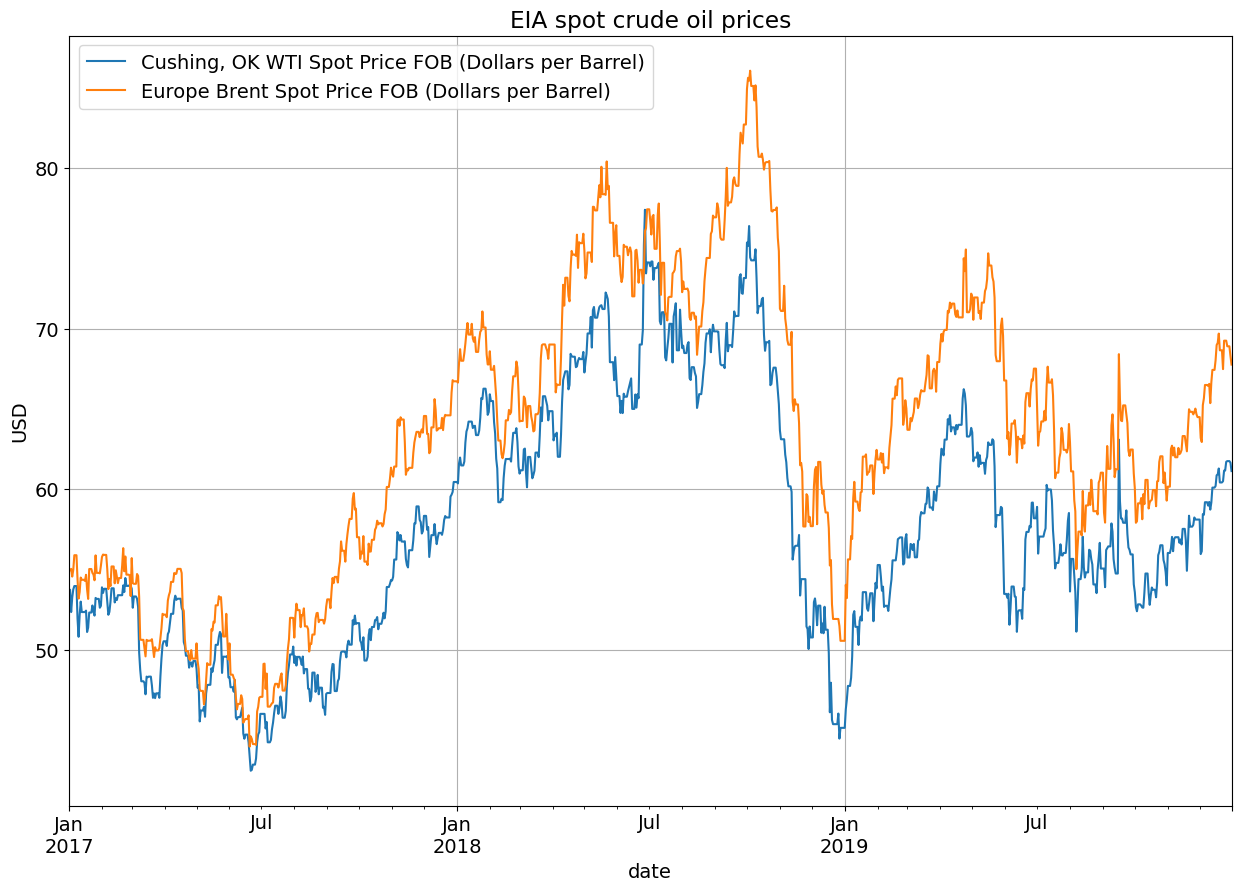

In [9]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#remove dates where crude oil prices are nrgative

We can see that crude prices increased significantly from 2017 to October 2018, where we saw a sharp rise from roughly $50/barrel to $85/barrel. the end of 2018 saw a drastic decrease in crude oil prices, declining by nearly 50%. 

The year 2019 witnessed a recovery following the dramatic drop of November 2018, rising to $75 from $45. 

We proceed the analysis with Cushing, OK WTI Spot Price, which is kept as a Pandas Series below. We choose WTI because EIA provides both spot and future prices for WTI, but not for Brent.

- The line below extracts the first column of information from the spot prices data frame, excluding Brent prices. 

In [10]:
spot_prices = spot_prices.iloc[:, 0]

Next we retrieve future prices also from EIA. We download the Excel file with the historical price data of NYMEX WTI Future contracts into a DataFrame.

In [11]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2017-01-01,53.72,54.66,55.43,56.05
2017-01-02,53.72,54.66,55.43,56.05
2017-01-03,52.33,53.29,54.12,54.81
2017-01-04,53.26,54.22,55.05,55.75
2017-01-05,53.76,54.68,55.49,56.17
...,...,...,...,...
2019-12-27,61.72,61.53,61.21,60.79
2019-12-28,61.72,61.53,61.21,60.79
2019-12-29,61.72,61.53,61.21,60.79
2019-12-30,61.68,61.44,61.10,60.66


The Data 1 sheet in the Excel file contains the prices of four different crude oil future contracts (Contract 1-4). "Contract 1" sets the physical delivery of crude oil in the month following the expiry date of the contract, "Contract 2" sets the delivery 2 months ahead, and so on until "Contract 4" (for details please refer here). A plot of the four future contract prices is shown below.

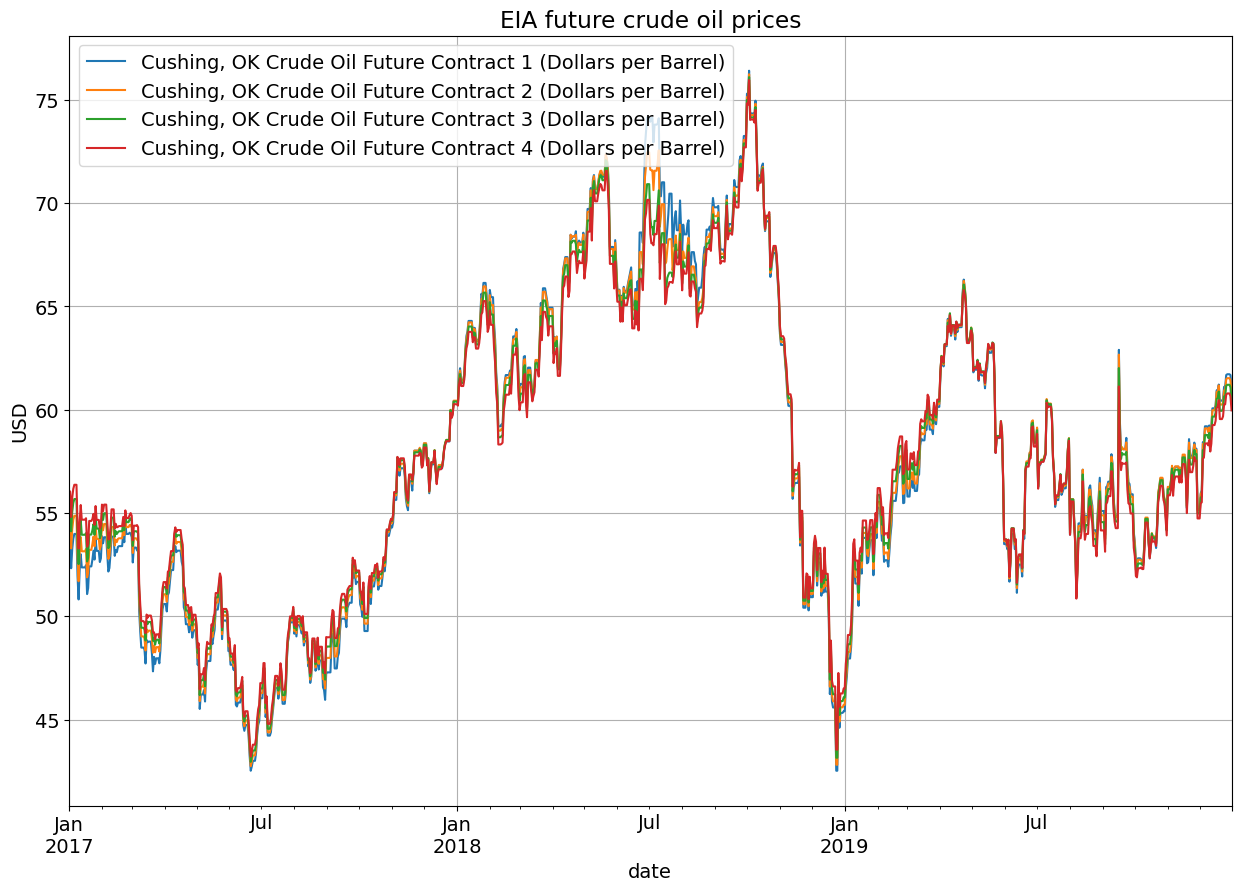

In [12]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

Next we calculate the difference between the future prices and the spot price, also known as calendar spread.

In [13]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2017-01-01,-0.03,0.91,1.68,2.30
2017-01-02,-0.03,0.91,1.68,2.30
2017-01-03,-0.03,0.93,1.76,2.45
2017-01-04,0.00,0.96,1.79,2.49
2017-01-05,-0.01,0.91,1.72,2.40
...,...,...,...,...
2019-12-27,-0.04,-0.23,-0.55,-0.97
2019-12-28,-0.04,-0.23,-0.55,-0.97
2019-12-29,-0.04,-0.23,-0.55,-0.97
2019-12-30,0.02,-0.22,-0.56,-1.00


Plotting the calendar spreads makes it easy to visualise the periods in which the crude oil market was in contango (spread > 0) and in backwardation (spread < 0).

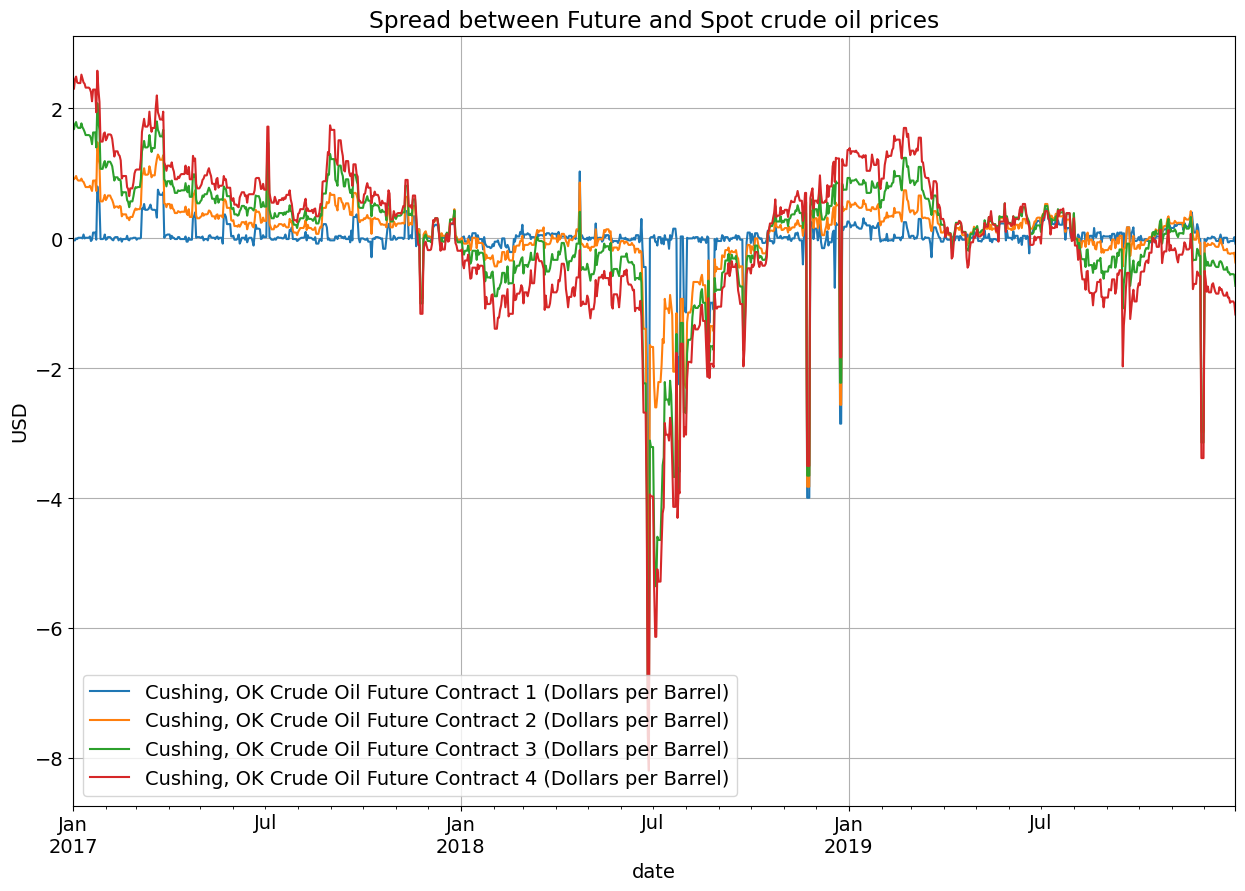

In [14]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

We will continue the analysis with "Cushing, OK Crude Oil Future Contract 4" future prices and the corresponding calendar spread, both as Pandas Series.

In [15]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

## Cross Correlation Analysis

In [16]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

We start investigating the relationship between floating storage and prices by doing a simple cross-correlation analysis. For this, we use the pandas.Series.corr function to compute the Pearson correlation coefficient between two time series as we slide one of them in time using the shift function.

In [17]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

To illustrate how this function works, let's look at the first few lags when we cross-correlated calendar_spread and floating_storage:

In [18]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.476352
1    0.479522
dtype: float64

All values are Pearson correlation coefficients between the two input variables. The index values correspond to the number of days the first variable is shifted "down" relative to the second one, so past values of the first variable are correlated against the present values of the second variable. In the above example, at index 1 "today's" floating storage is correlated with "yesterday's" calendar spread, or equivalently the calendar spread is correlated against floating storage 1 day in the future.

To help visualise the cross-correlation between the different variables, we define the following function:

In [19]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

plot_crosscorr splits the cross-correlation results in two: the top plot has the correlation values between series_x and future values of series_y, and the bottom plot the correlation between series_y and future values of series_x. Plotting the cross-correlation between calendar spread and floating storage we obtain:

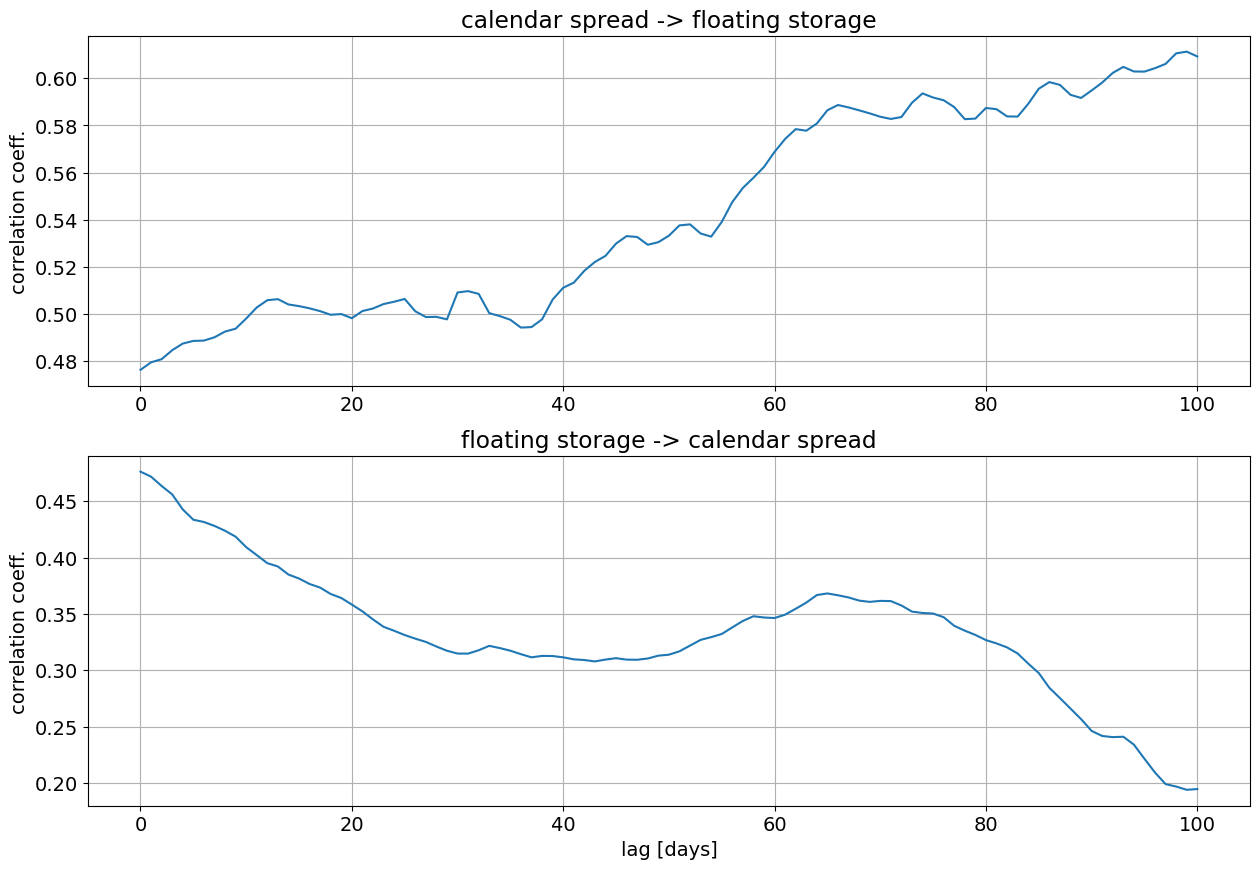

In [20]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

- By having two plots we will be able to analyse which direction the effect is strongest and which is the leading variable

- Plot 1 checks how well calendar spread leads floating storage at different lags. A high correlation at a positive lag would suggest that changes in calendar spread can predict future storage levels i.e. changes in calendar spread are followed by changes in floating storage with some delay. So, if calendar spread widens, floating storage should also follow suit and increase over time. Because the largest correlation coefficient value is after the largest lag, the effect of calendar spread on floating storage becomes more pronounced over time. 

- Plot 2 checks how well floating storage leads calendar spread at different lags. A lower correlation at a positive lag would suggest that changes in floating storage have less predictive power for future calendar spread. The declining correlation implies that an increase in floating storage today is not necessarily followed by a corresponding widening or narrowing of spread in the future. 

- Calendar spread and floating storage are positively correlated over the entire range of lag values examined. The largest value corresponds to the correlation between calendar spread and floating storage around 60 days into the future (top plot).

Next we cross correlate spot prices and floating storage

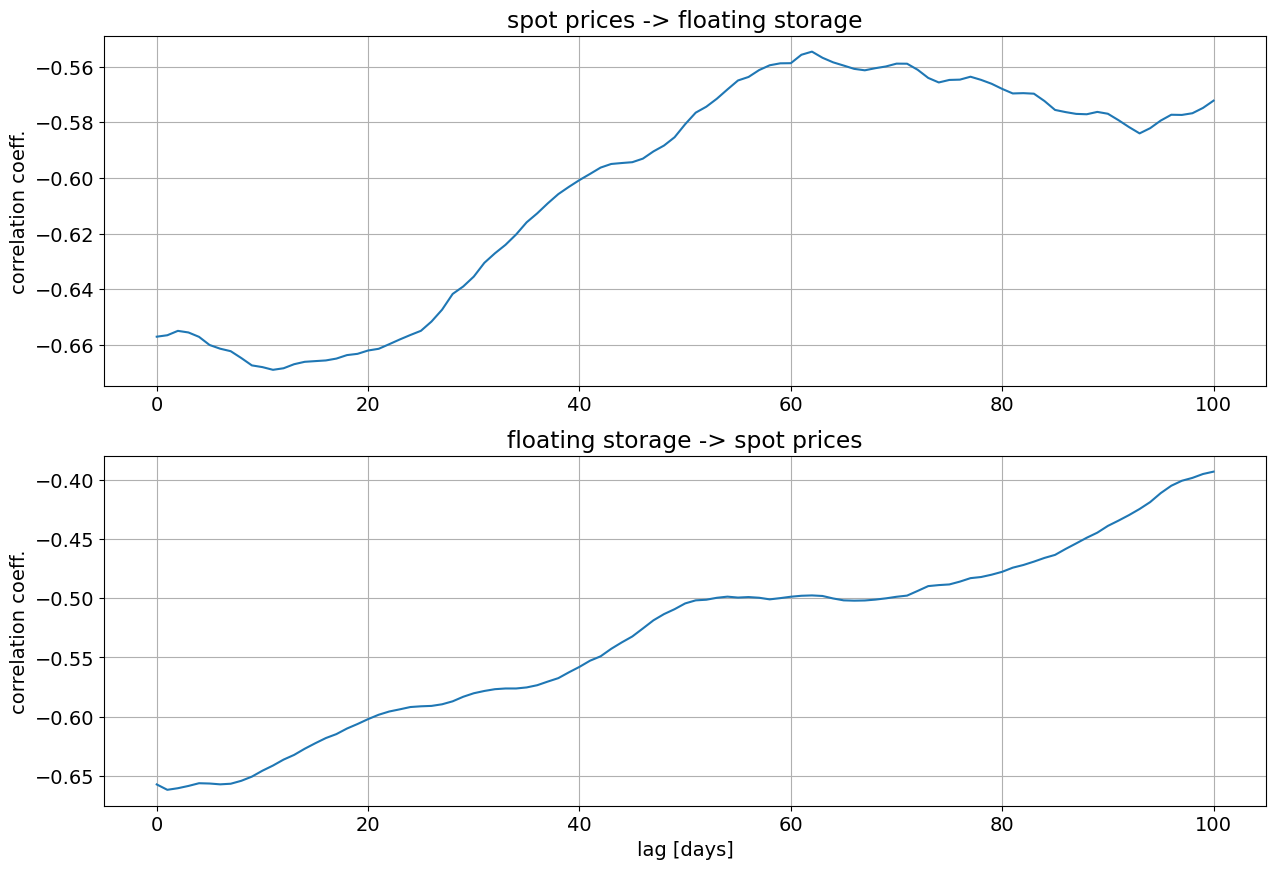

In [21]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

Spot prices are negatively correlated with floating storage over the entire range of lag values. The largest negative amplitude was found when spot prices were correlated with floating storage ~60 days in the future.

We use the crosscorr function to calculate and plot the autocorrelation of each time series (alternatively one can use pd.Series.autocorr iteratively).

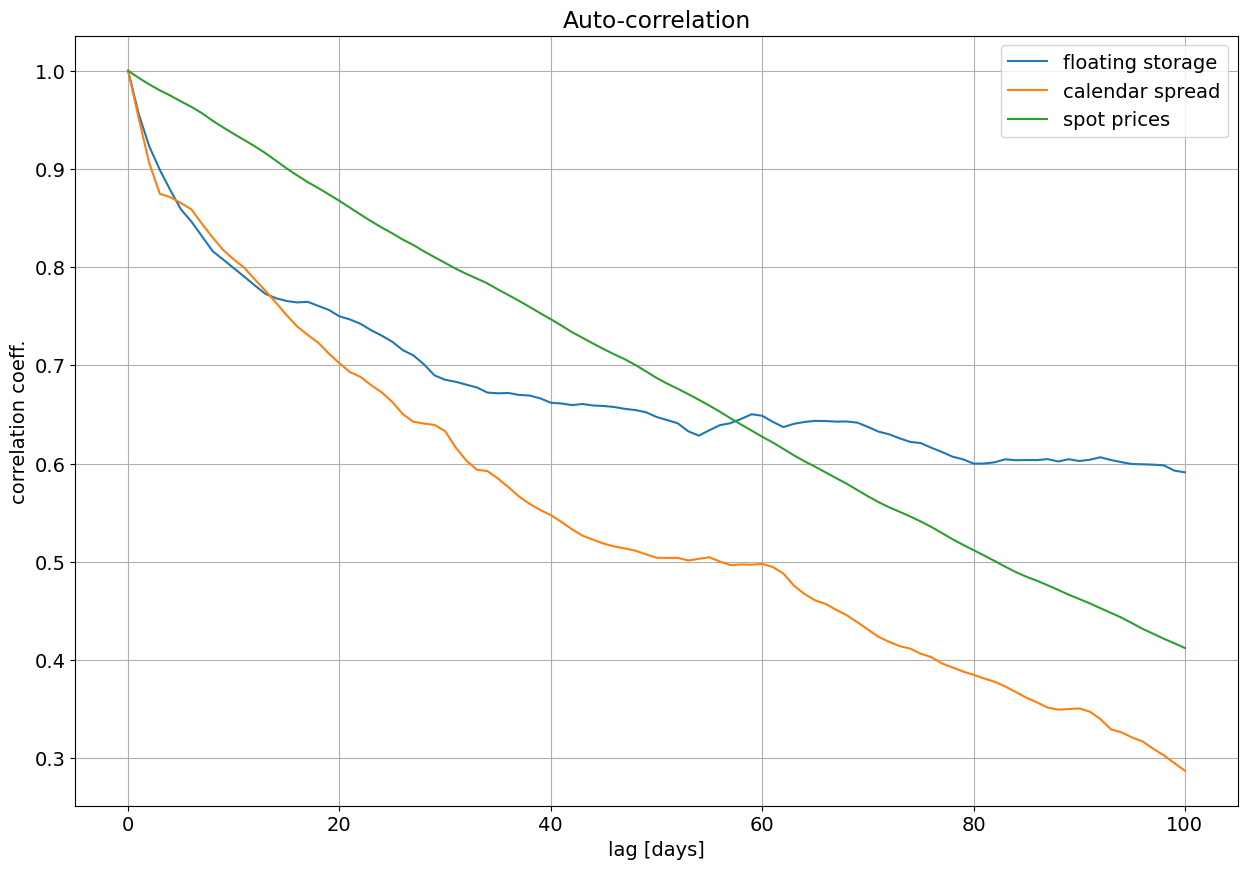

In [22]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

The above graph shows the autocorrelation of 3 variables; floating storage, calendar spread and spot prices. We continually increase the lag so as to compare each series today with its own past. A faster decay would indicate the series loses correlation with its past more quickly which implies more volatility. A slower decay would indicate that the variable remembers its past values for longer. Our findings are as follows: 

- Calendar Spread: The fastest decaying series. After 20 days its correlation coefficient is much lower than the others and this difference continues to increase. We can interpret this as calendar spreads changing relatively quickly over time, implying that their values forget past levels quicker. 

- Floating storage also declines rapidly at early lags but eventually remains more correlated with itself over longer horizons. What does this mean with real life application? Stored crude volumes are slow to change in the short term but in the medium-long run they display inertia and remain fairly resilient.

- Spot prices decay the slowest and maintain a gradual decline. It appears that they have strong persistence across 0 to 100 days. Interestingly, around 55 days lag, spot prices move below the floating storage line. This suggests that after 2 months, spot prices become less correlated with their own past compared to floating storage. It makes sense - spot prices can be susceptible to short term, news-based shocks but over time these shocks dissipate. 

## Granger Causality Analysis

In [23]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2762  , p=0.0024  , df_denom=1091, df_num=1
ssr based chi2 test:   chi2=9.3017  , p=0.0023  , df=1
likelihood ratio test: chi2=9.2624  , p=0.0023  , df=1
parameter F test:         F=9.2762  , p=0.0024  , df_denom=1091, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4018  , p=0.0125  , df_denom=1088, df_num=2
ssr based chi2 test:   chi2=8.8440  , p=0.0120  , df=2
likelihood ratio test: chi2=8.8084  , p=0.0122  , df=2
parameter F test:         F=4.4018  , p=0.0125  , df_denom=1088, df_num=2


The p‐values we see are below 0.05, we reject the null hypothesis that floating_storage does not Granger‐cause calendar_spread at both 1 and 2 lags. i.e. The lower p-values at lag 1, relative to a lag of 2, suggest that the influence of floating storage on calendar spread is stronger at shorter lags but still present at 2 lags. 
This suggests an underlying economic mechanism where variations in stored crude volumes anticipate the shape or level of the futures curve.


In [24]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


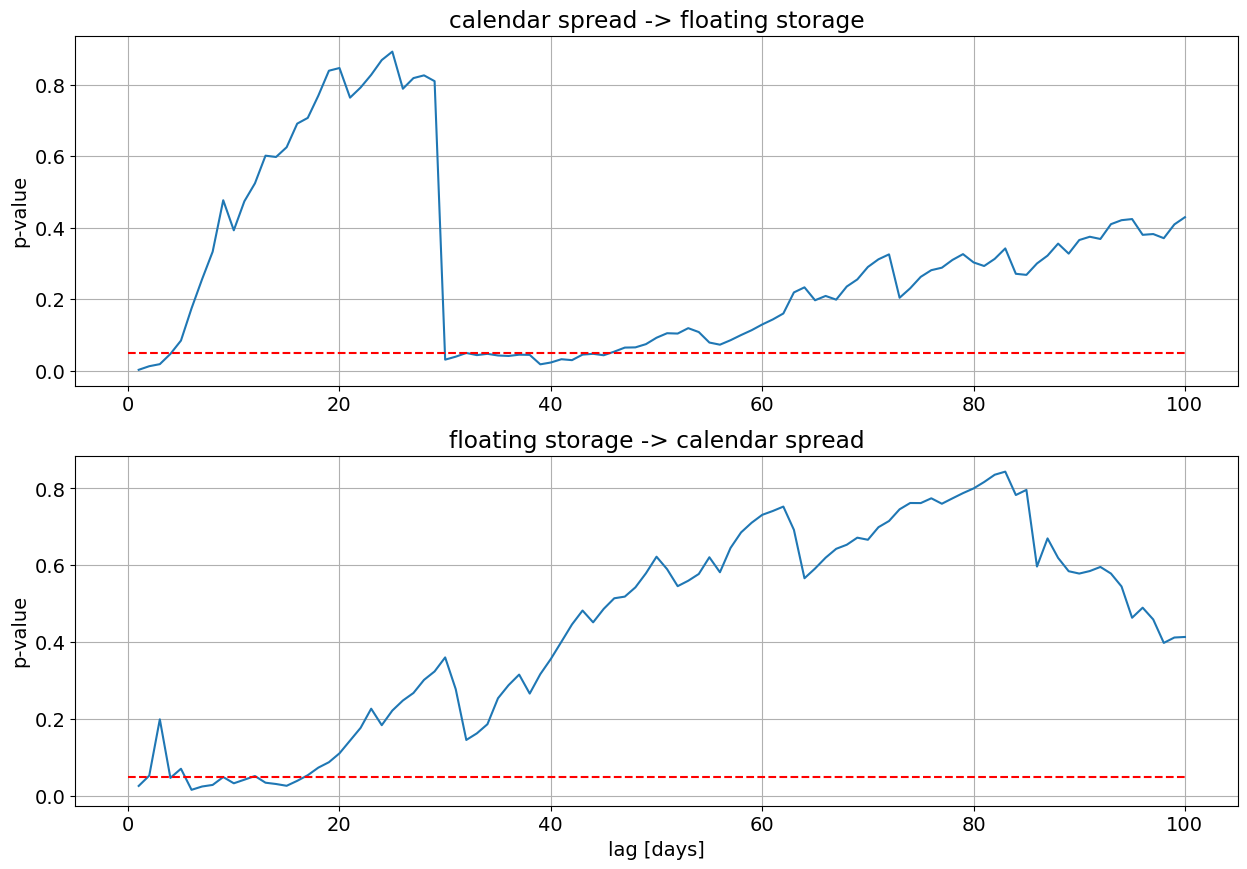

In [25]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

The blue lines indicate the p-values of the Granger causality tests, and to identify the significant results we need to look where the p-values dip below the threshold of significance (dashed red lines, set at the conventional threshold of 0.05), meaning that one variable causes the other at that specific lag.

- The Top Plot

This graph illustrates whether past values of calendar spread help to predict floating storage levels. The p-values start below 0.05 at very low lags, indicating statistical significance in this relationship. However, they quickly increase maintaining levels above 0.05 between 5 and 30 days. There is a brief return to below 0.05 between 30-45 days but this is short lives and p-values continually increase between 45 and 100 days lag. 


- The Bottom Plot

Floating storage likewise shows significance at smaller lags (under 10 days) and becomes insignificant at other larger lag ranges. This indicates some short‐run predictive power but no stable significance over longer periods.


For both plots, these graphs suggest that there may be short intervals/windows of lag where each series can help to predict each other but for the large part, especially over larger lags, there is no stable statistical significance. 

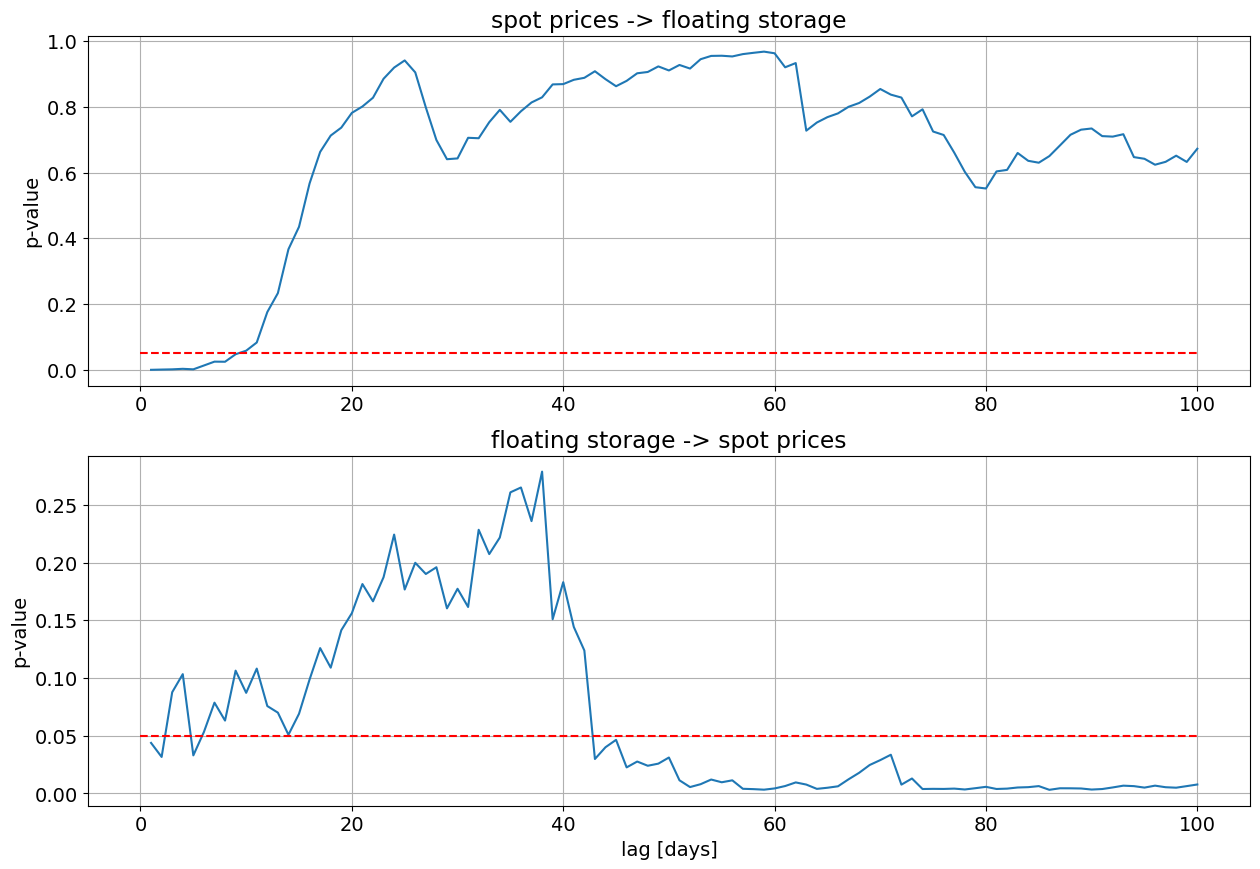

In [26]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

- The Top Plot (Showing if past values of spot prices help to predict floating storage levels)

Some significance at short term lags with p-values below 0.05 between 0-10 lags, meaning that in the short term, spot prices appear to have predictive power for floating storage levels. Beyond that, their predictive power wanes.  

- The Bottom Plot (Showing if past values of floating storage help to predict spot prices)

After lag ~40, the line drops below 0.05 and mostly stays there, indicating significance for lags higher than 40. In the short to medium range there isn't much predictive power but at longer horizons there looks to be some predictive ability which is surprising. 

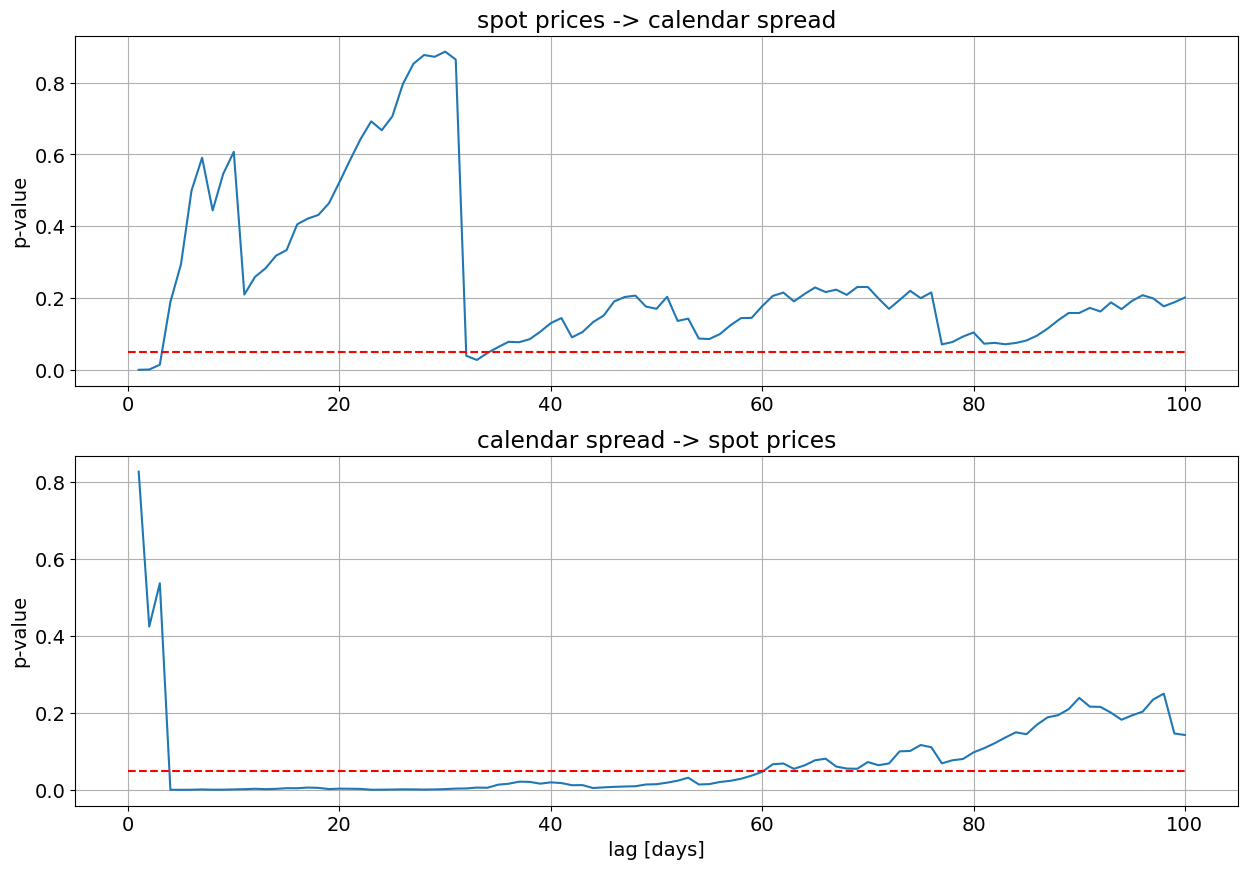

In [27]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')

In the top plot, p-values are significant for short term lags between 0 and 35 days. Beyond this they rise above 0.05. Meaning that spot prices can granger cause calendar spread in the short term but over the long run, the statistical significance of this effect weakens. 

In the bottom plot, p-values remain close to 0 between 5-60 days and then lose their statistical significance. This can be interpreted as calendar spreads having predictive power and granger causing spot price levels in the short - medium run. 